In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import random
import os
from tqdm import tqdm 
import plotly.io as pio
pio.renderers.default = 'colab'

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

import gudhi as gd
import gudhi.representations

In [ ]:
from architecture, import Encoder, Decoder

# Import dataset

In [2]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

/Users/michaelmontelli/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/torch/csrc/utils/tensor_numpy.cpp:180.)



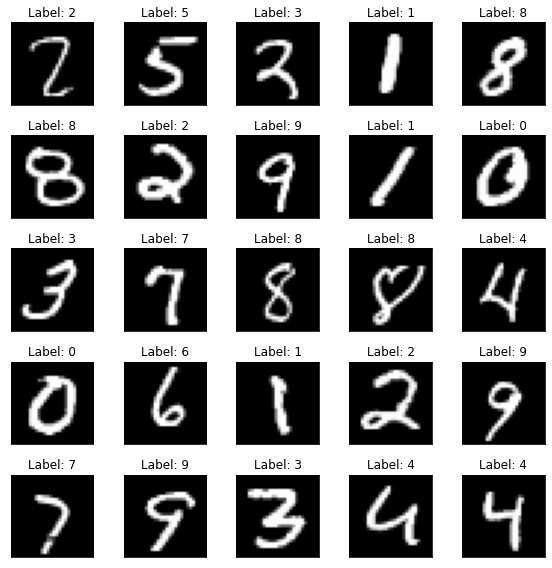

In [3]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

In [5]:
m = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size = 256


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# Loss

In [8]:
torch.manual_seed(0)

d = 3

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d, fc2_input_dim=128)

In [9]:
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)


img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)


dec_img = decoder(img_enc)

print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 3])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [10]:
loss_fn = torch.nn.MSELoss()

lr = 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
#optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=6e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
#model.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# Train and test

In [11]:
def make_simplicial_complex(encoded_data, number_of_points):
    if number_of_points == 256:
        points = encoded_data
    else:
        points = random.sample(encoded_data, number_of_points)
    rips_complex = gd.RipsComplex(points=points, max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    return simplex_tree

In [12]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    
    for image_batch, _ in dataloader:  # ignore labels
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        
        encoded_data = encoder(image_batch)
        
        decoded_data = decoder(encoded_data)
        
        loss = loss_fn(decoded_data, image_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [13]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            
            encoded_data = encoder(image_batch)
            
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [14]:
def plot_ae_outputs(encoder, decoder, n=5):
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            encoded_img = encoder(img)
            rec_img = decoder(encoded_img)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()   

In [15]:
def plot_persistence_landscapes(encoder, decoder, n=100):
    points = []
    labels = []
    for i in range(n):
        img = test_dataset[i][0].unsqueeze(0).to(device)
        label = test_dataset[i][1]
        labels.append(label)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            encoded_img = encoder(img)
            rec_img = decoder(encoded_img)
        encoded_img = encoded_img.flatten().cpu().numpy()
        points.append(encoded_img)
    skeleton = gd.RipsComplex(points=points, max_edge_length=1.7)
    simplex_tree = skeleton.create_simplex_tree(max_dimension=2)
    barcodes = simplex_tree.persistence()
#     for barcode in barcodes:
#         print(barcode)
    LS = gd.representations.Landscape(num_landscapes=5, resolution=n)
    L = LS.fit_transform([simplex_tree.persistence_intervals_in_dimension(1)])
    for i in range(3):
        plt.plot(L[0][i * n:(i+1) * n])
    plt.show()
    plot_encoded_points(np.array(points), labels)

In [16]:
def plot_persistence_landscapes2(encoder, decoder, n=10):
    points = []
    labels = []
    zero_samples = [sample for sample in test_dataset if sample[1] == 0]
    for i in range(n):
        img = zero_samples[i][0].unsqueeze(0).to(device)
        label = zero_samples[i][1]
        labels.append(label)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            encoded_img = encoder(img)
            rec_img = decoder(encoded_img)
        encoded_img = encoded_img.flatten().cpu().numpy()
        points.append(encoded_img)
    skeleton = gd.RipsComplex(points=points, max_edge_length=1.7)
    simplex_tree = skeleton.create_simplex_tree(max_dimension=2)
    barcodes = simplex_tree.persistence()
#     for barcode in barcodes:
#         print(barcode)
    LS = gd.representations.Landscape(num_landscapes=5, resolution=n)
    L = LS.fit_transform([simplex_tree.persistence_intervals_in_dimension(1)])
    for i in range(3):
        plt.plot(L[0][i * n:(i+1) * n])
    plt.show()
    plot_encoded_points(np.array(points), labels)

In [17]:
def plot_encoded_points(encoded_samples, labels):
    fig = plt.figure(figsize=(24, 12))
    ax = fig.add_subplot(projection='3d')

    xs, ys, zs = encoded_samples[:, 0], encoded_samples[:, 1], encoded_samples[:, 2]
    sc = ax.scatter(xs, ys, zs, c=labels, cmap='tab10')
    fig.colorbar(sc)
    plt.show()


 EPOCH 1/30 	 train loss 0.133 	 val loss 0.082


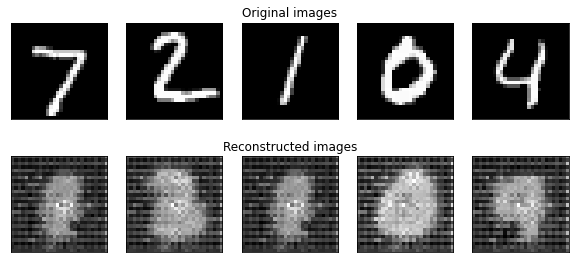

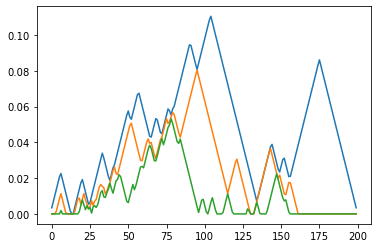

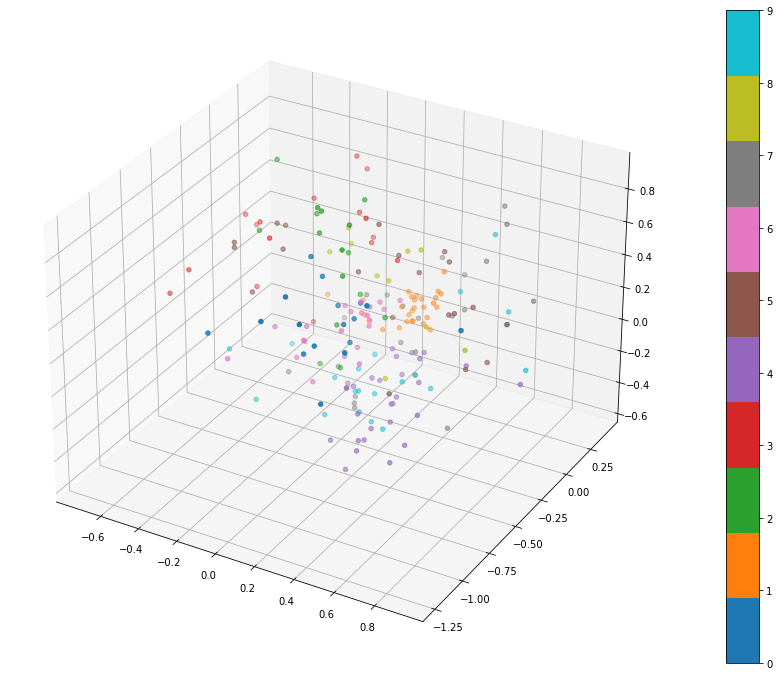


 EPOCH 2/30 	 train loss 0.061 	 val loss 0.047


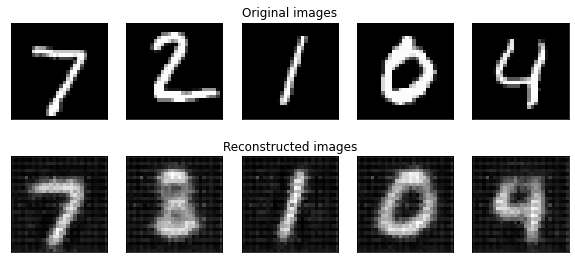

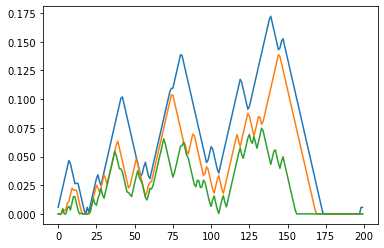

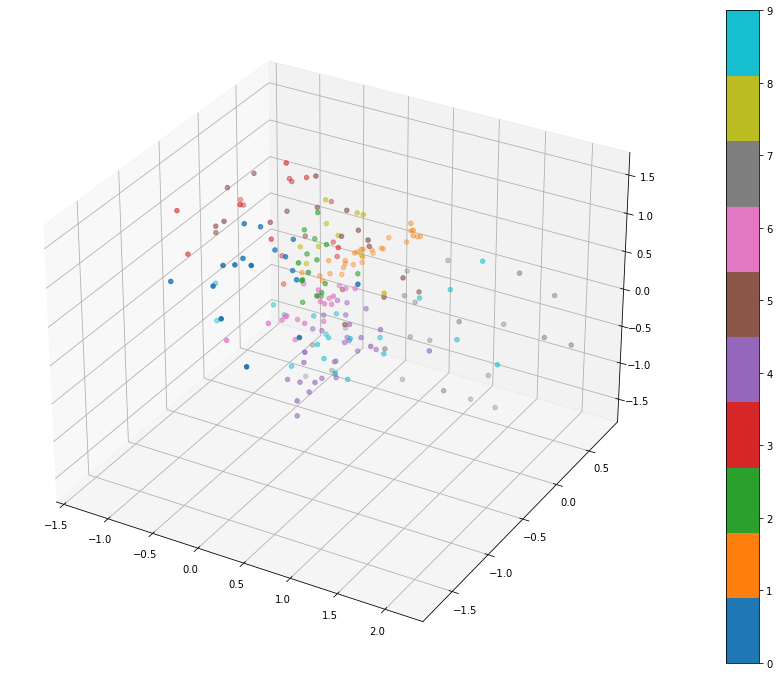


 EPOCH 3/30 	 train loss 0.043 	 val loss 0.039


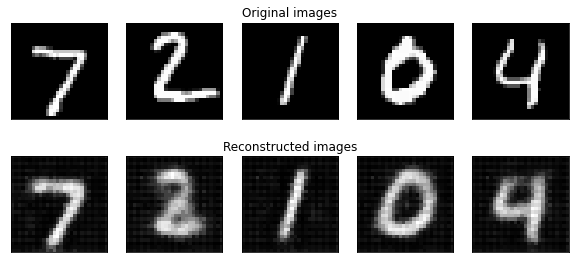

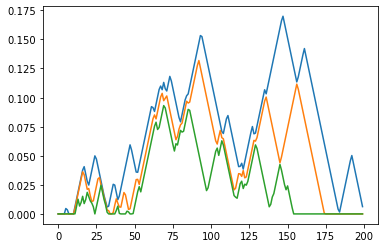

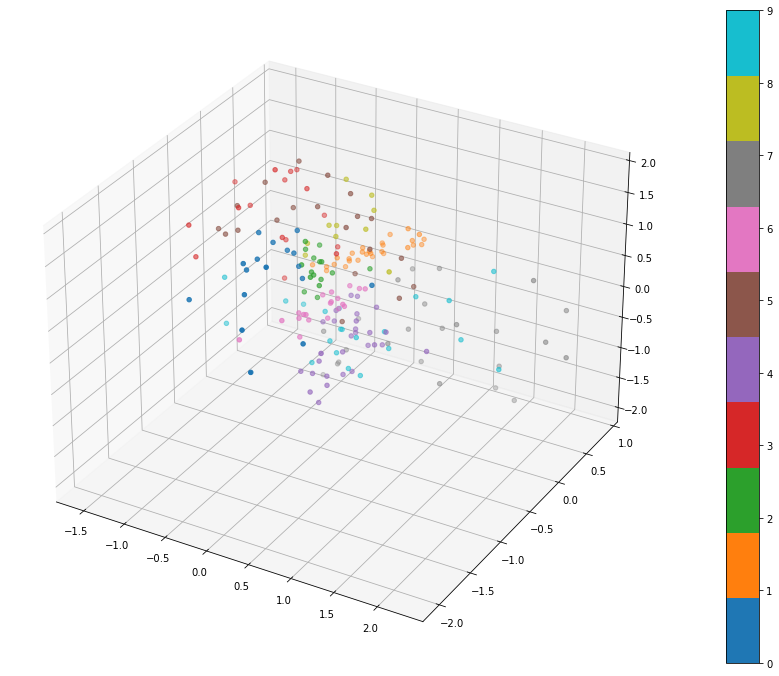


 EPOCH 4/30 	 train loss 0.038 	 val loss 0.037


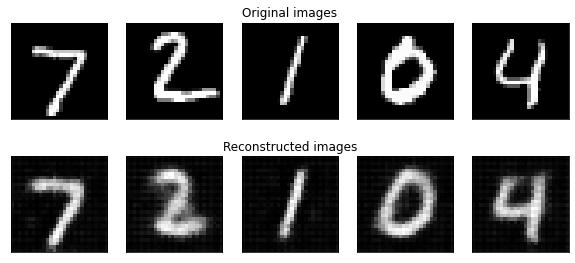

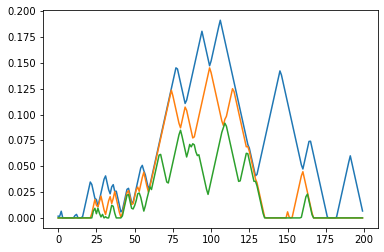

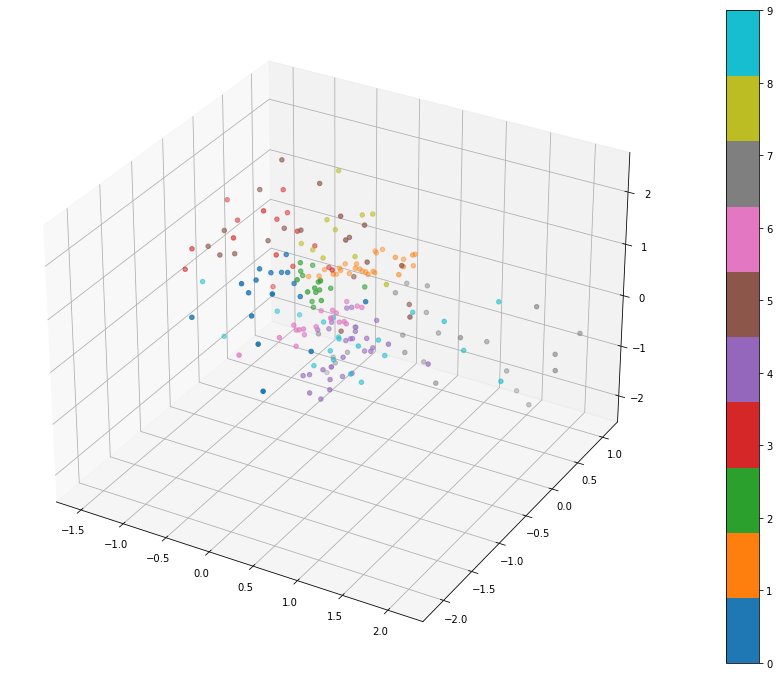


 EPOCH 5/30 	 train loss 0.036 	 val loss 0.035


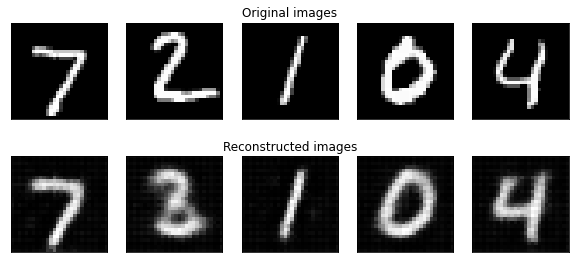

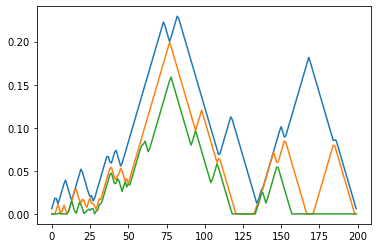

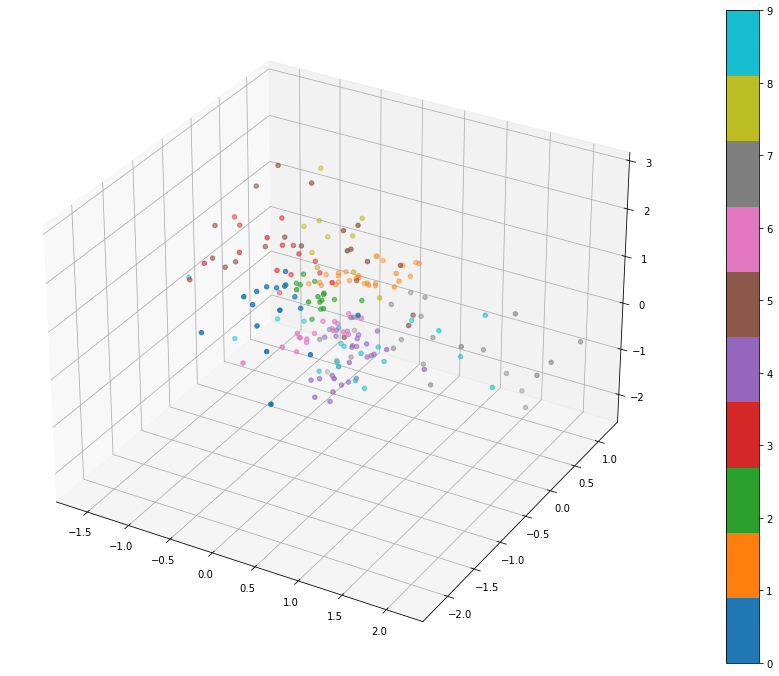


 EPOCH 6/30 	 train loss 0.035 	 val loss 0.034


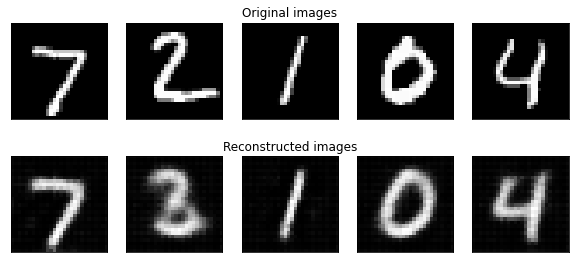

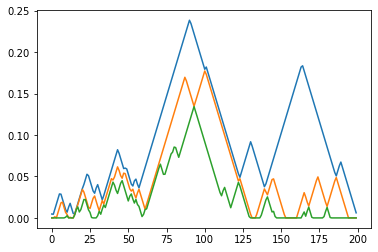

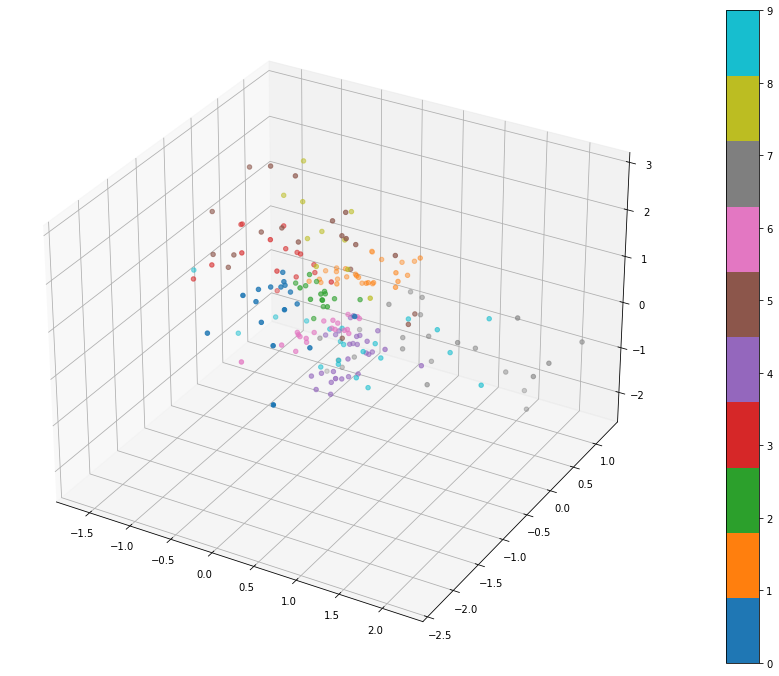


 EPOCH 7/30 	 train loss 0.035 	 val loss 0.034


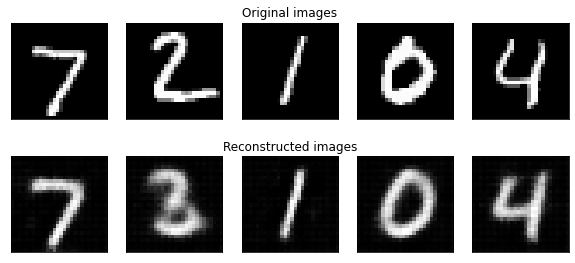

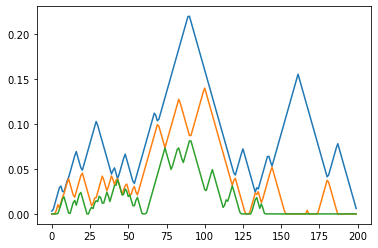

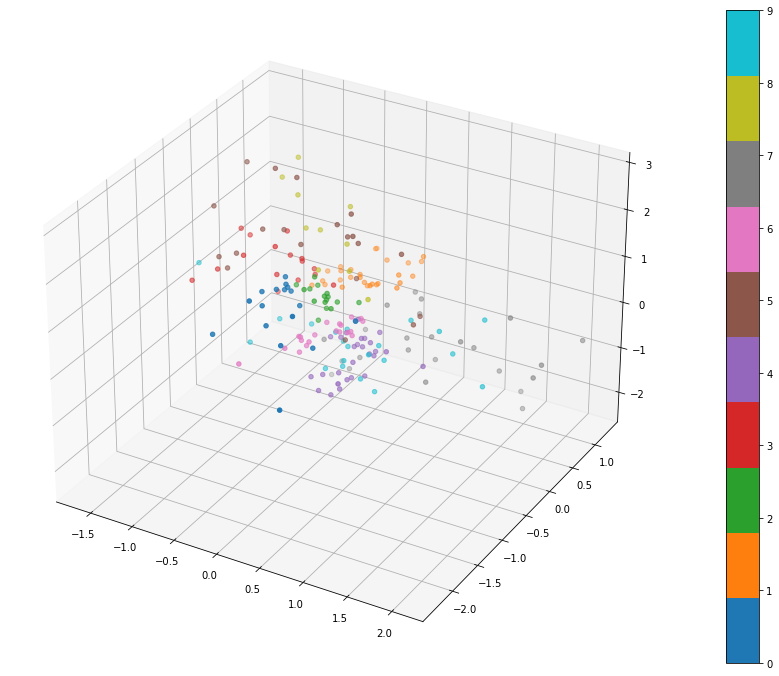


 EPOCH 8/30 	 train loss 0.034 	 val loss 0.033


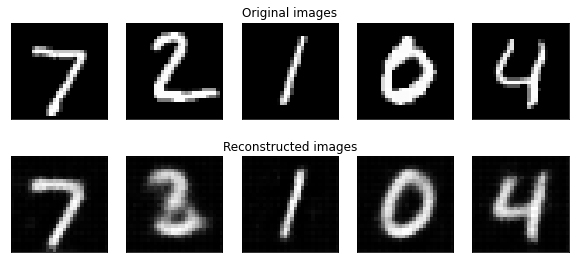

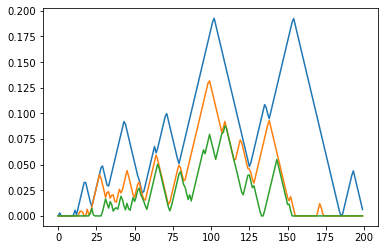

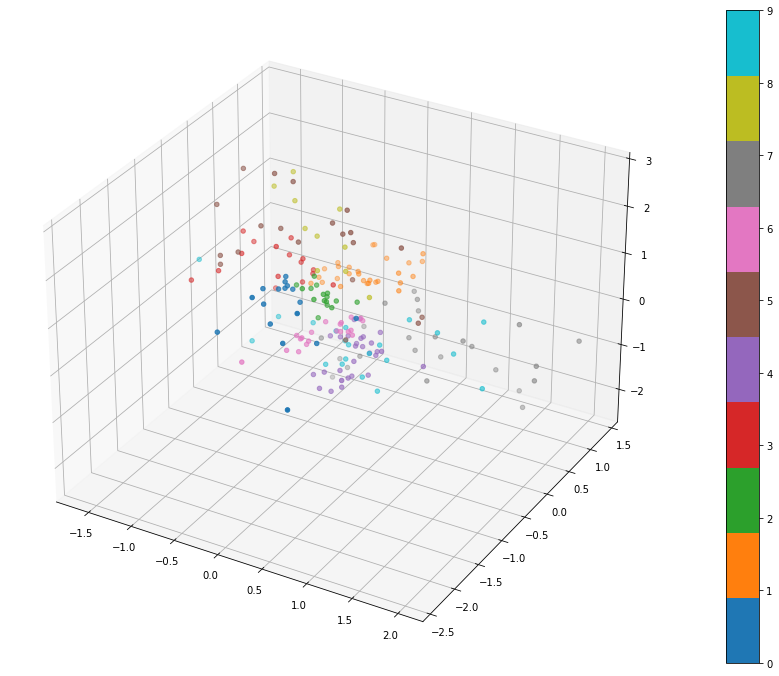


 EPOCH 9/30 	 train loss 0.033 	 val loss 0.033


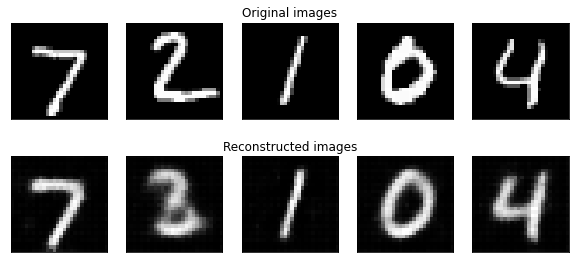

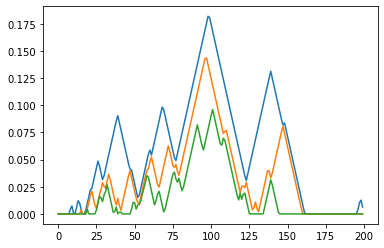

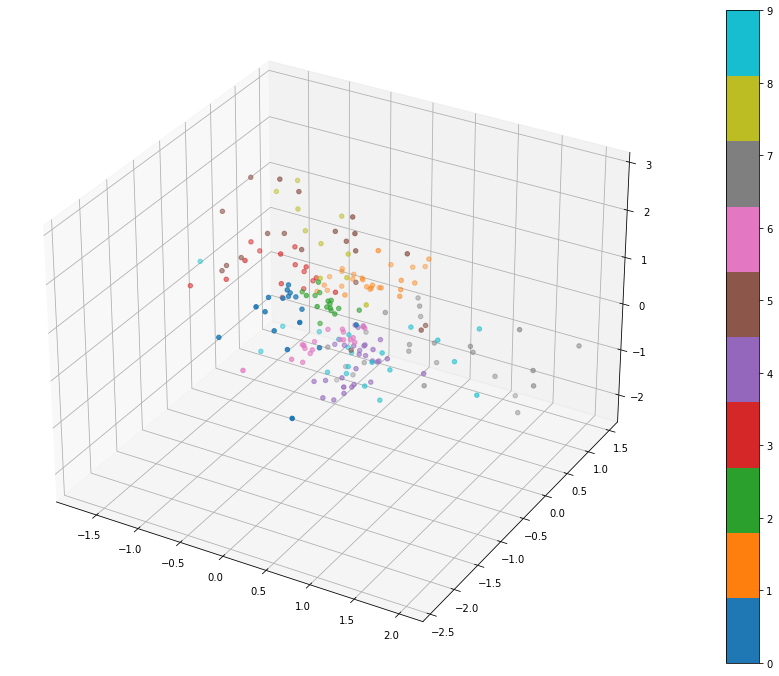


 EPOCH 10/30 	 train loss 0.033 	 val loss 0.033


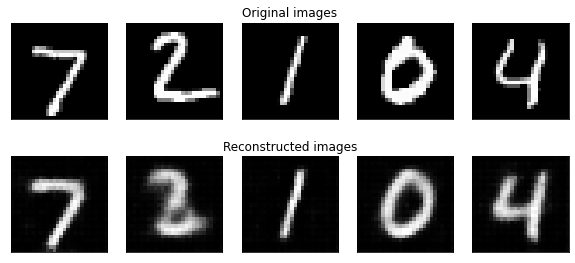

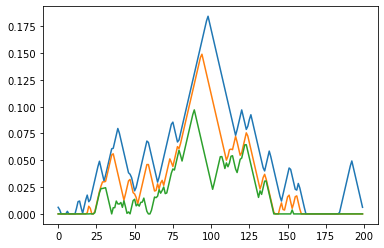

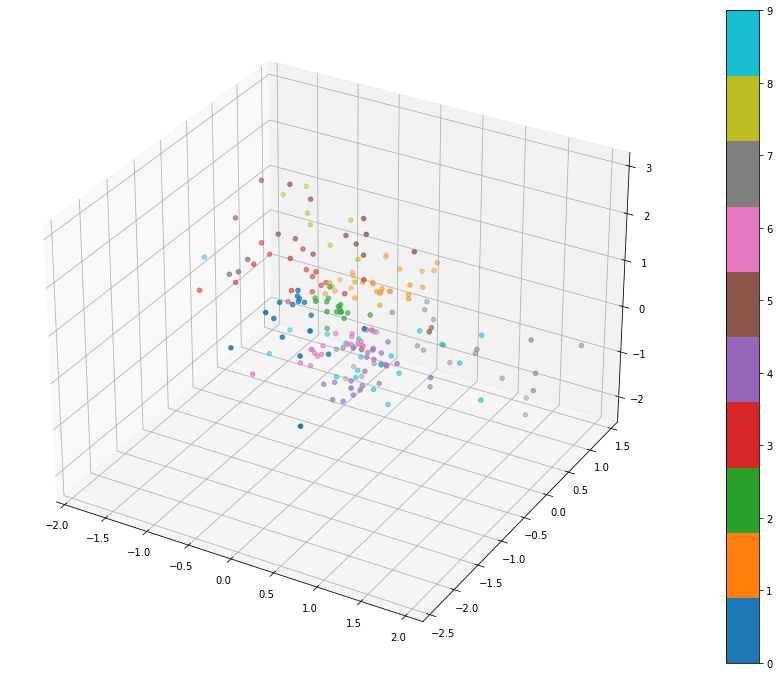


 EPOCH 11/30 	 train loss 0.033 	 val loss 0.032


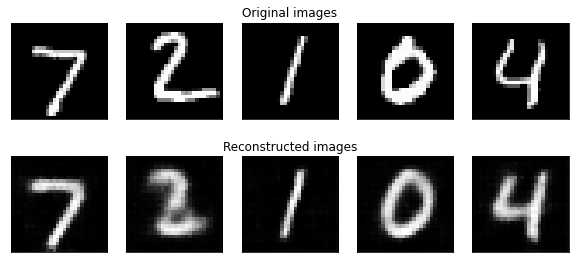

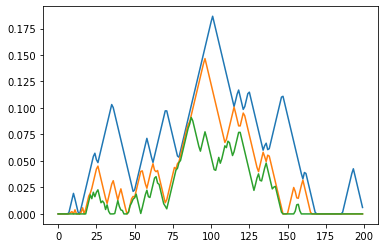

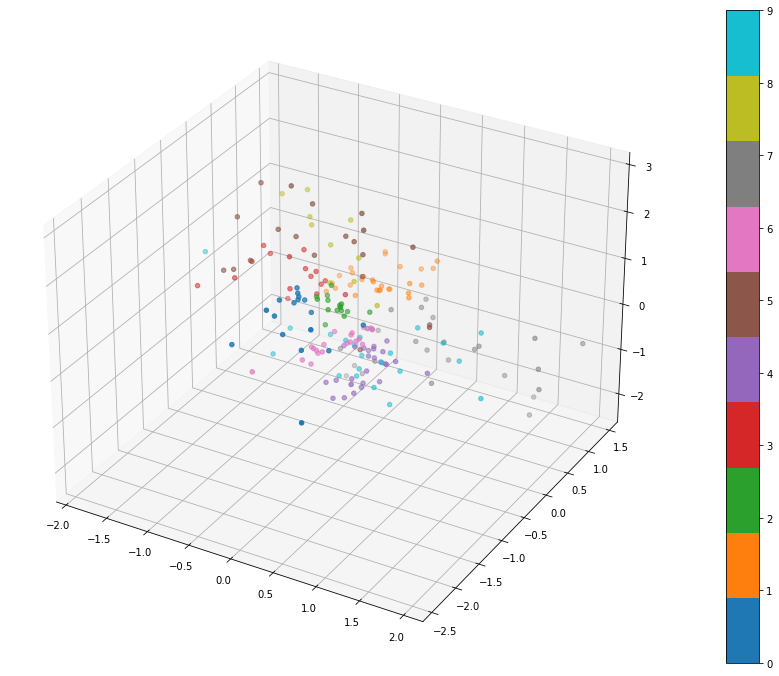


 EPOCH 12/30 	 train loss 0.032 	 val loss 0.032


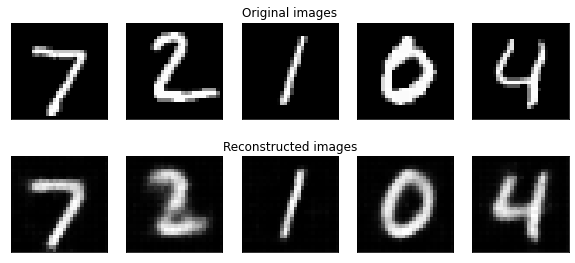

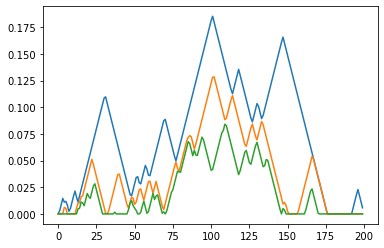

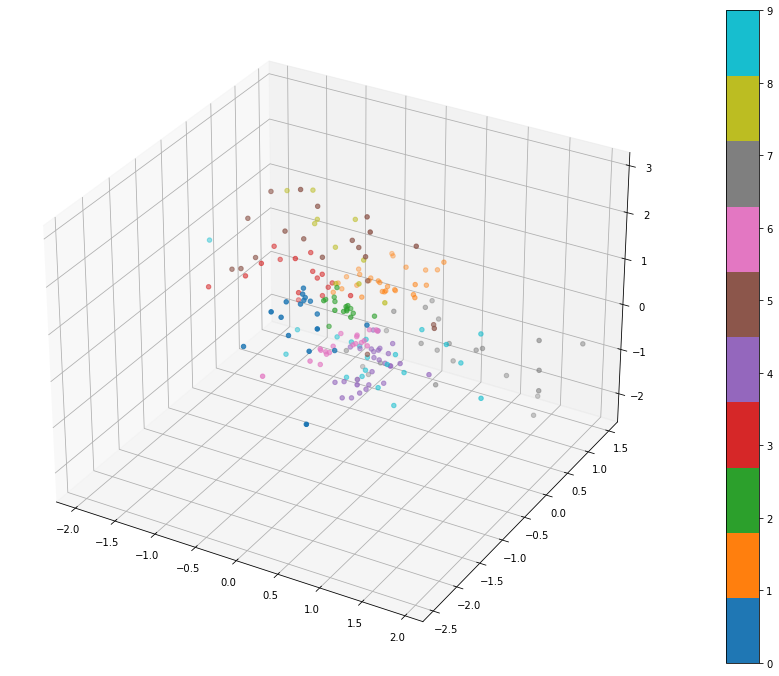


 EPOCH 13/30 	 train loss 0.032 	 val loss 0.032


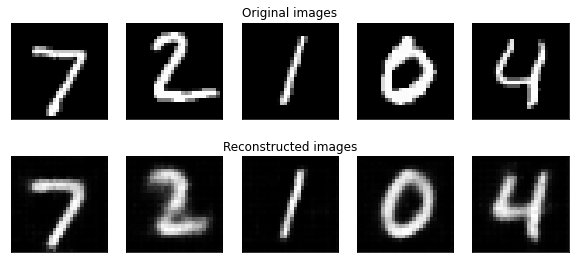

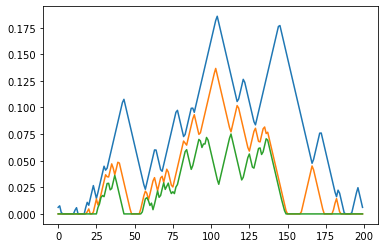

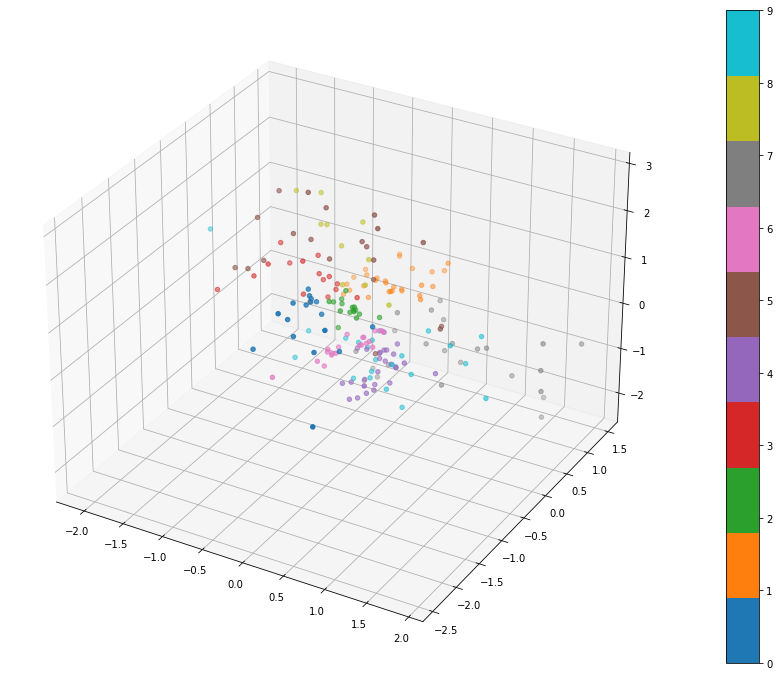


 EPOCH 14/30 	 train loss 0.032 	 val loss 0.032


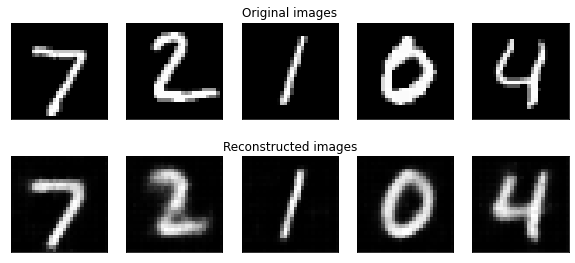

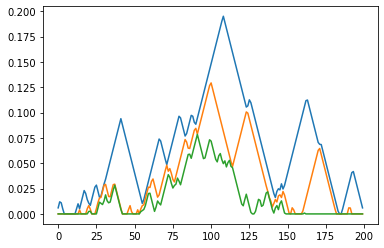

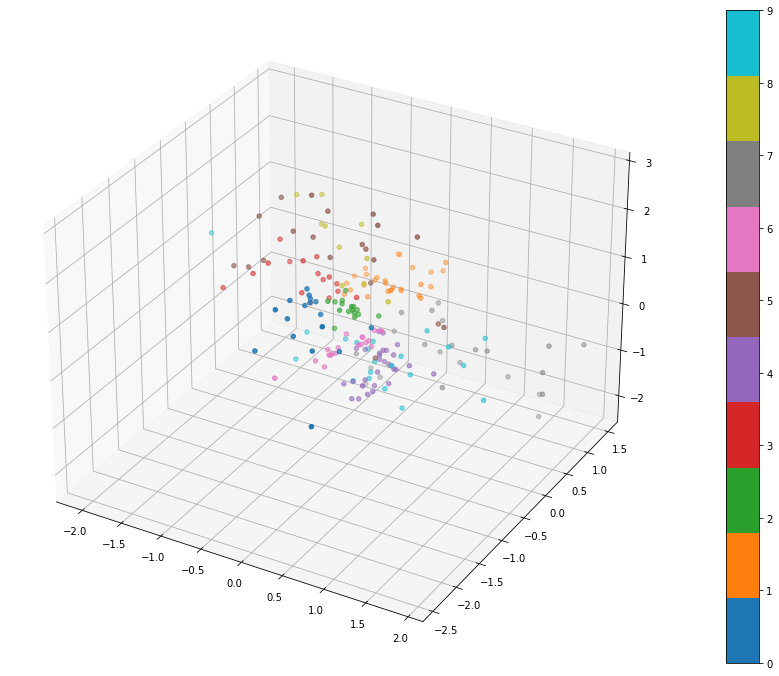


 EPOCH 15/30 	 train loss 0.032 	 val loss 0.032


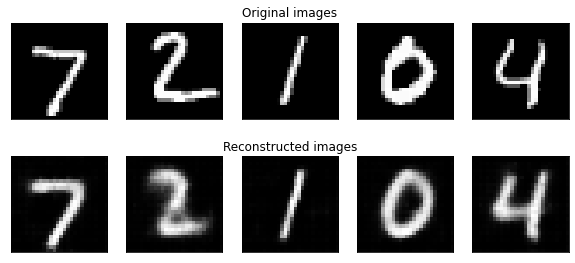

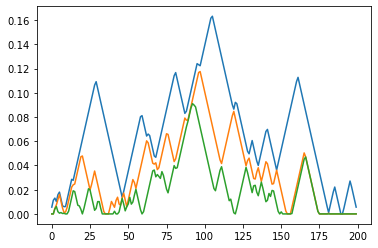

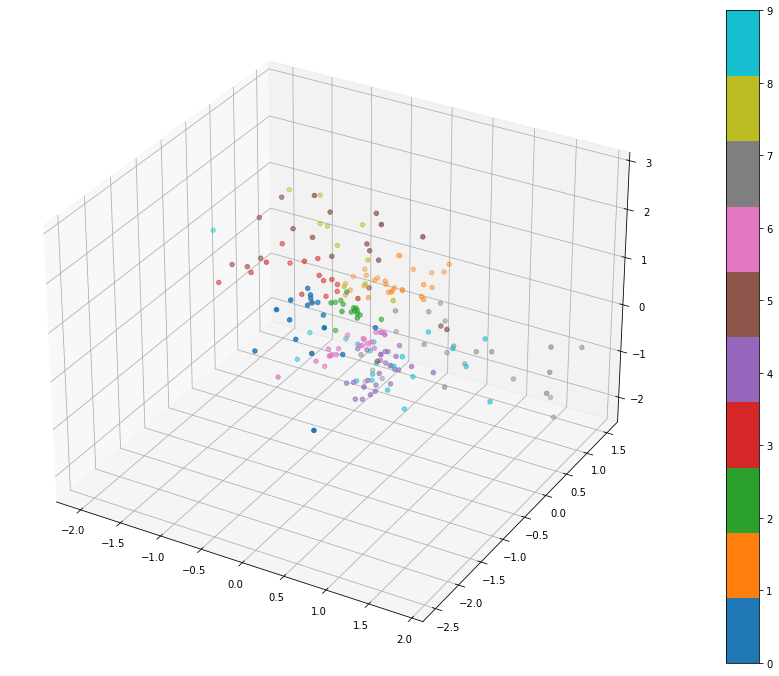


 EPOCH 16/30 	 train loss 0.032 	 val loss 0.032


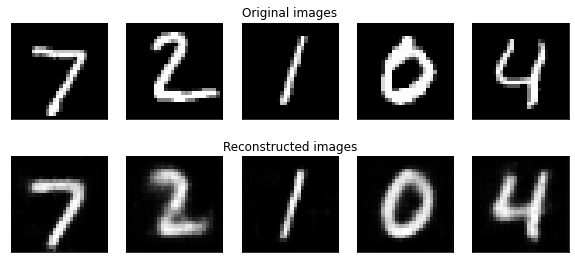

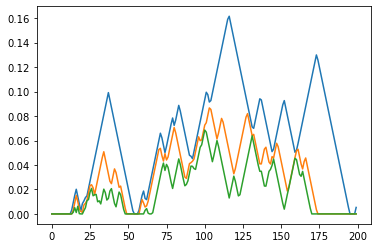

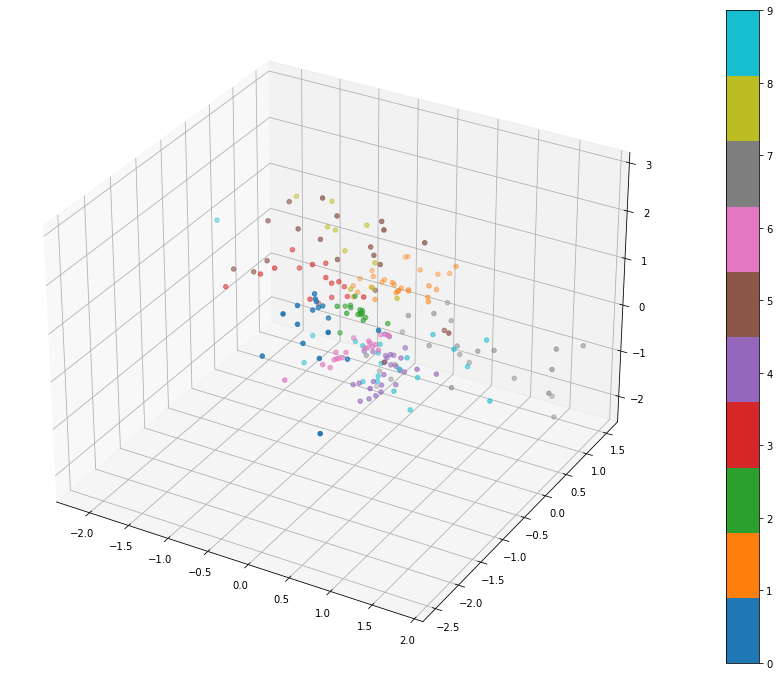


 EPOCH 17/30 	 train loss 0.032 	 val loss 0.031


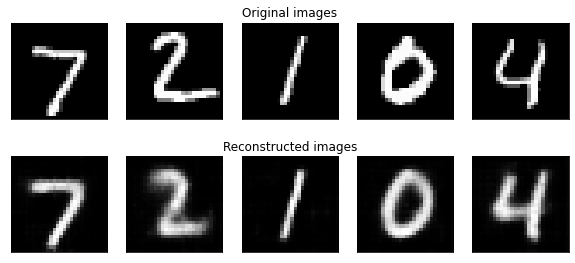

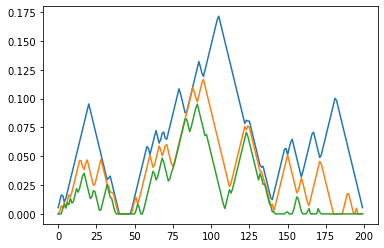

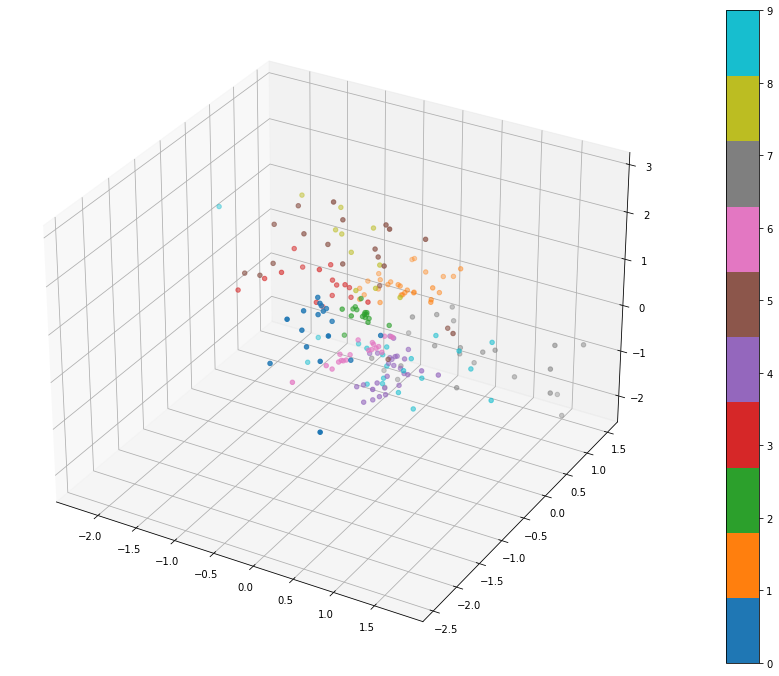


 EPOCH 18/30 	 train loss 0.031 	 val loss 0.031


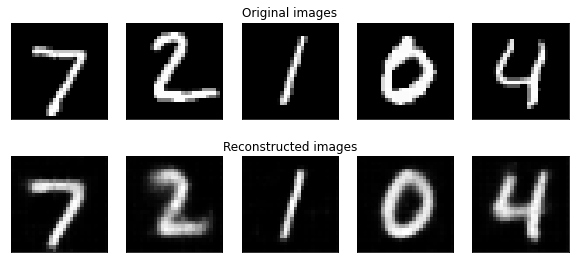

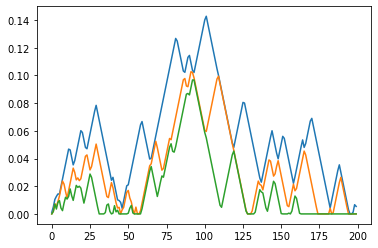

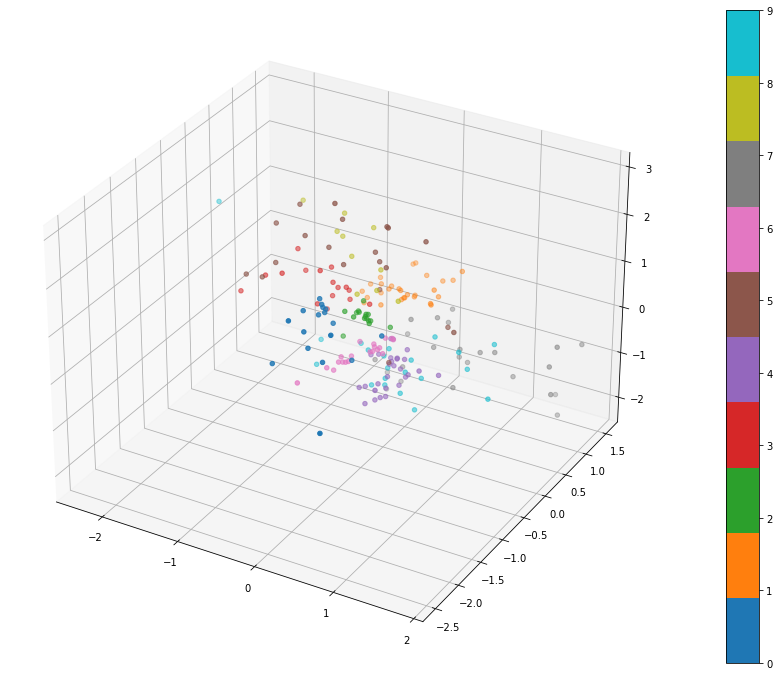


 EPOCH 19/30 	 train loss 0.031 	 val loss 0.031


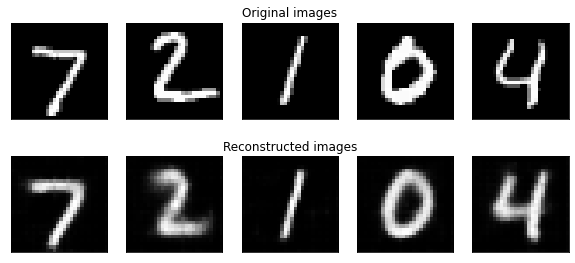

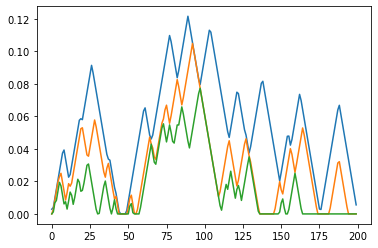

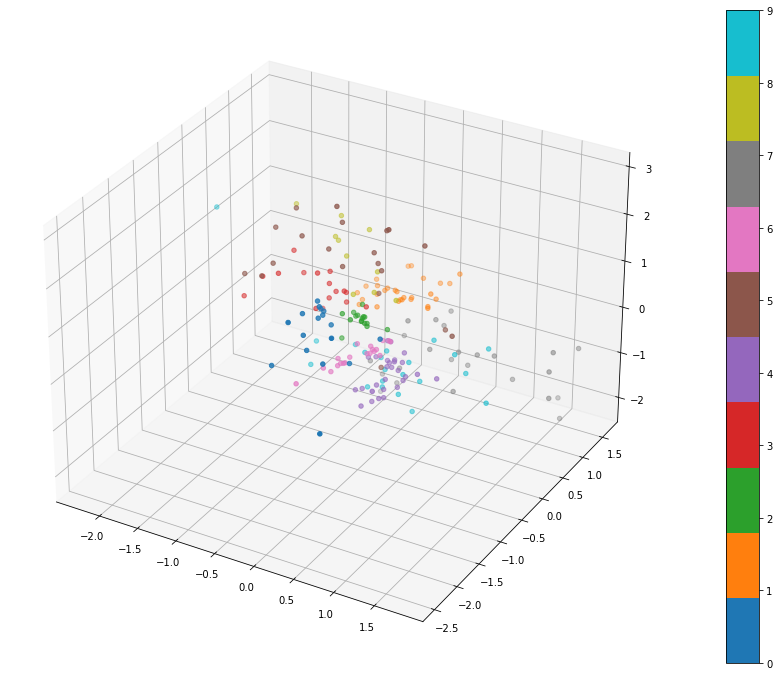


 EPOCH 20/30 	 train loss 0.031 	 val loss 0.031


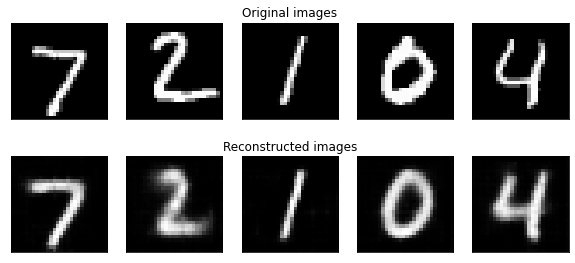

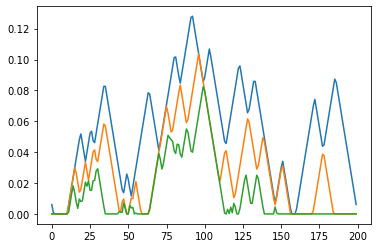

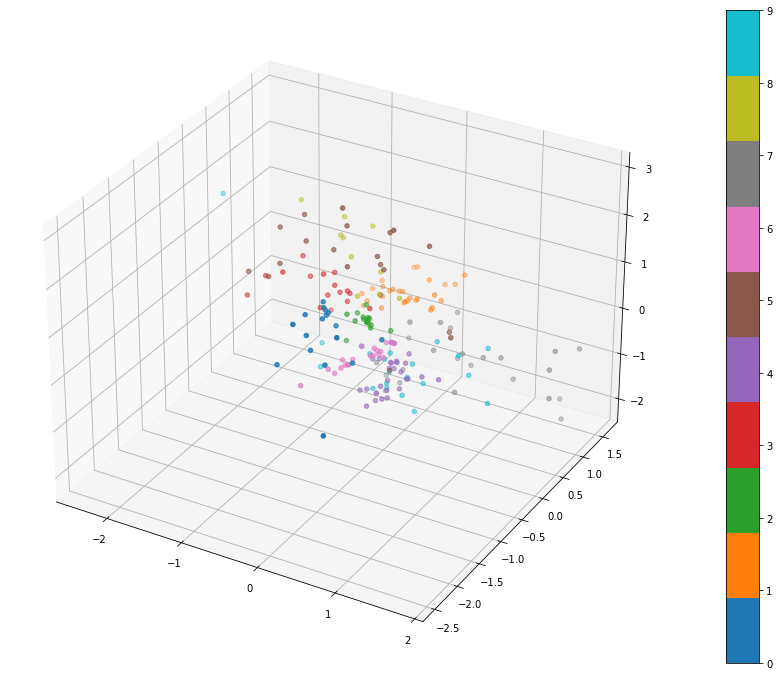


 EPOCH 21/30 	 train loss 0.031 	 val loss 0.031


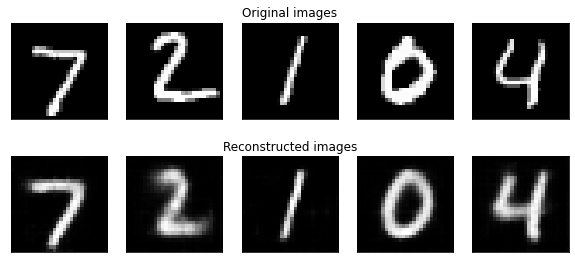

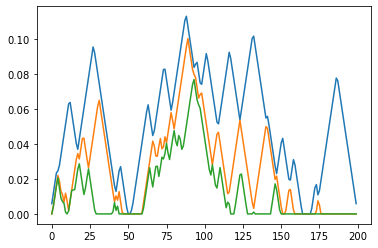

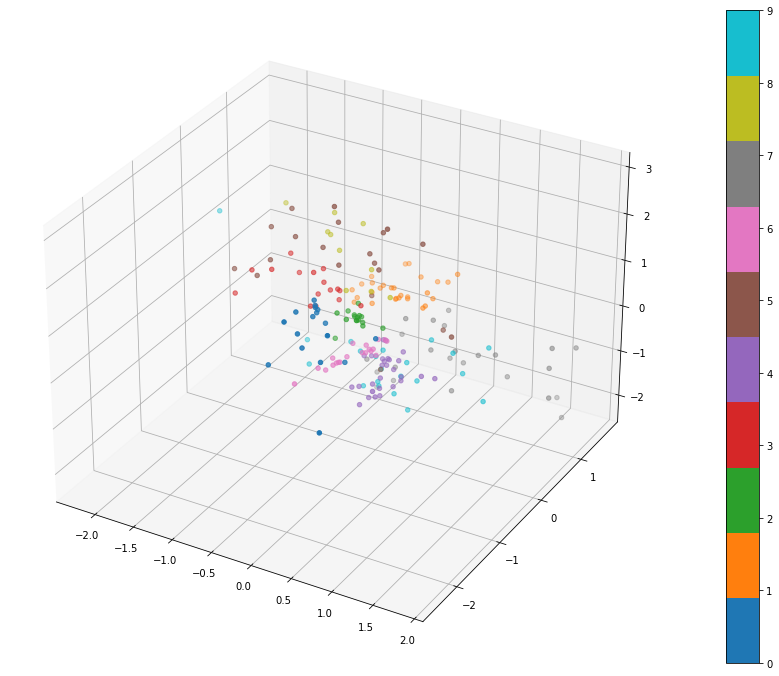


 EPOCH 22/30 	 train loss 0.031 	 val loss 0.031


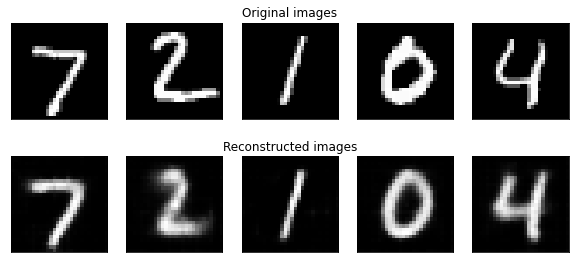

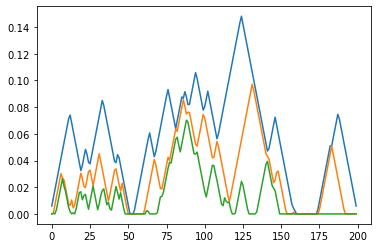

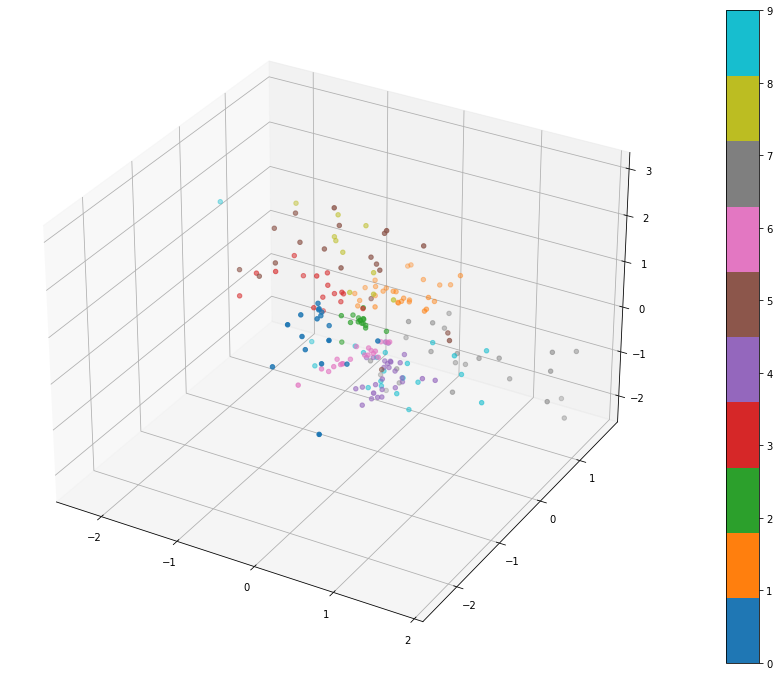


 EPOCH 23/30 	 train loss 0.031 	 val loss 0.031


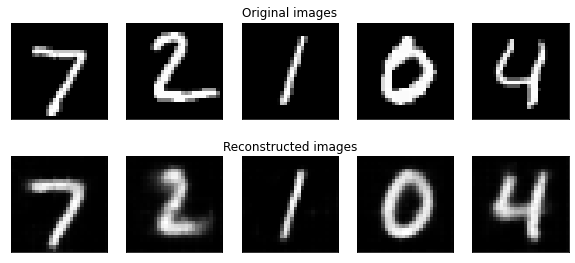

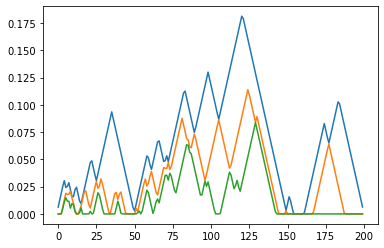

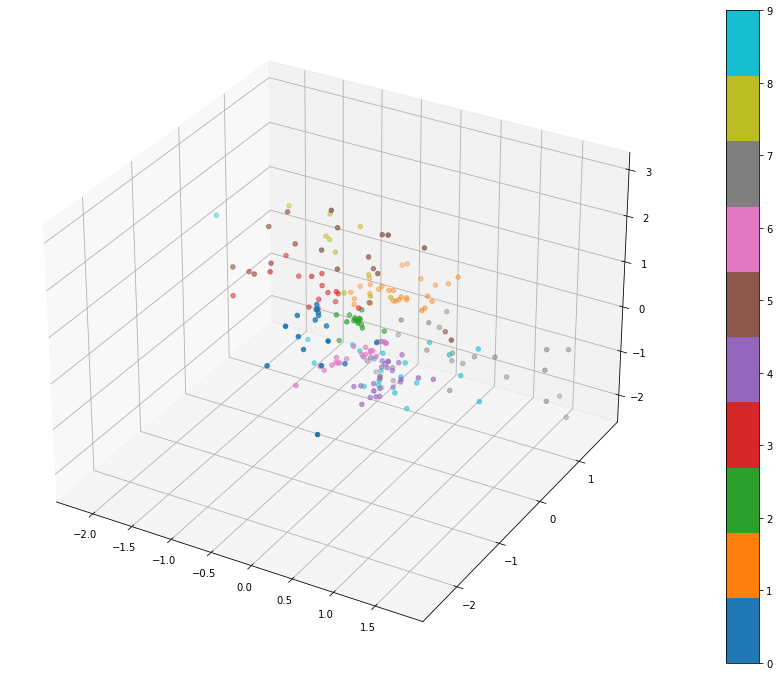


 EPOCH 24/30 	 train loss 0.031 	 val loss 0.031


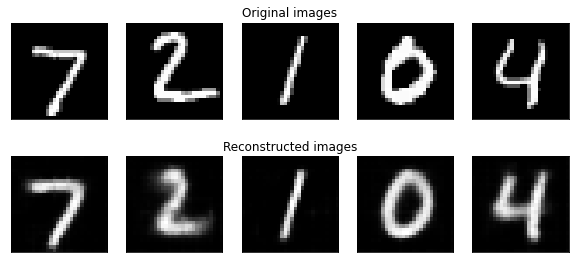

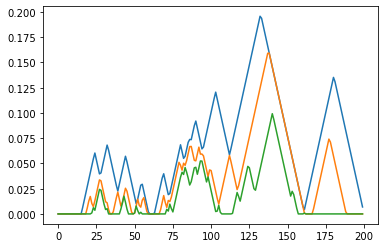

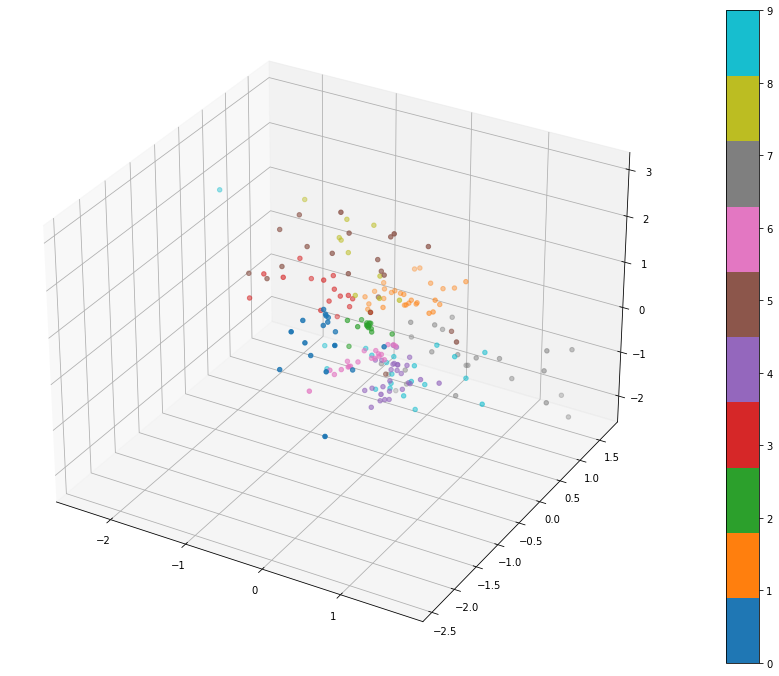


 EPOCH 25/30 	 train loss 0.031 	 val loss 0.031


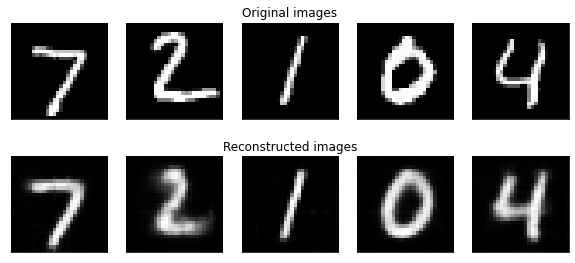

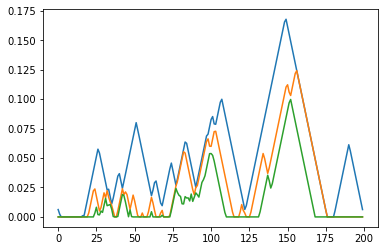

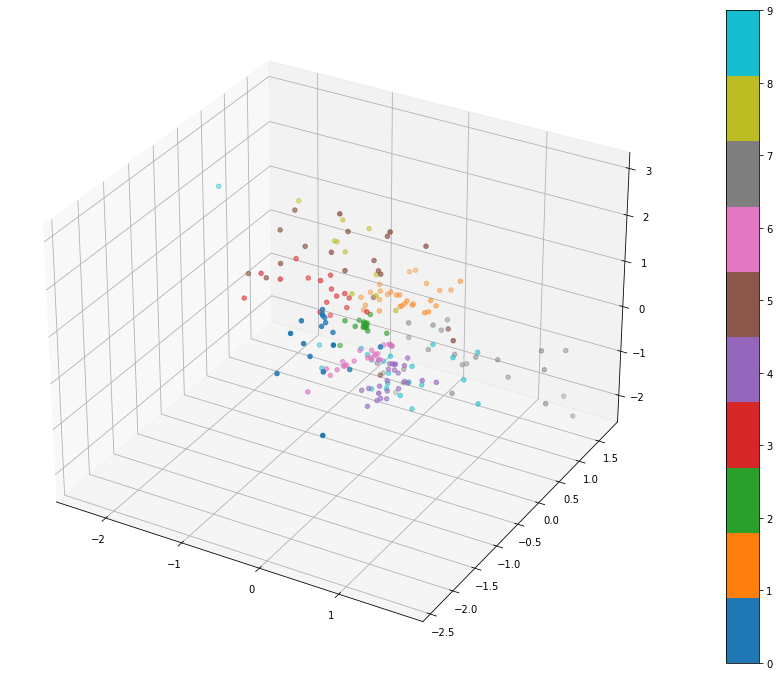


 EPOCH 26/30 	 train loss 0.031 	 val loss 0.031


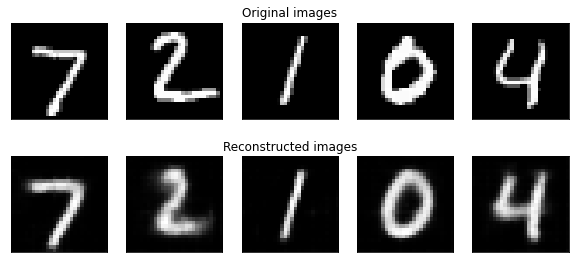

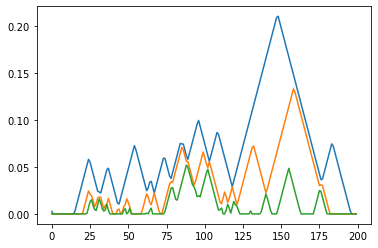

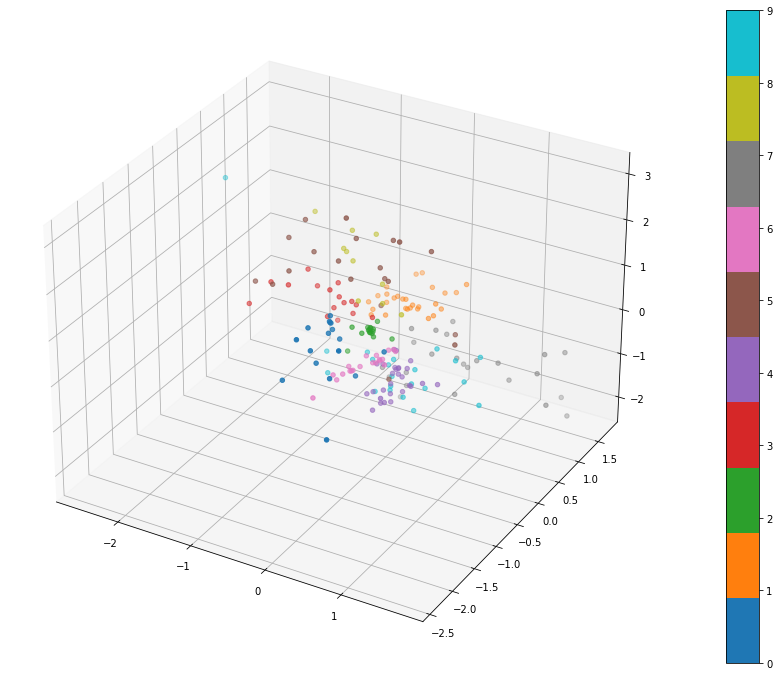


 EPOCH 27/30 	 train loss 0.031 	 val loss 0.031


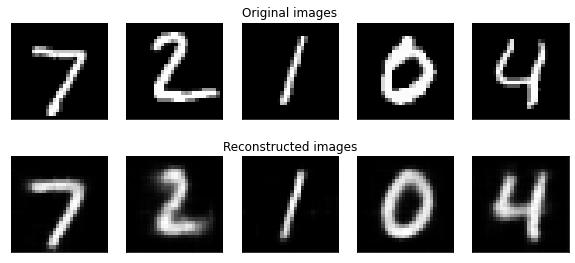

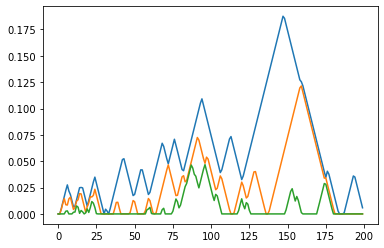

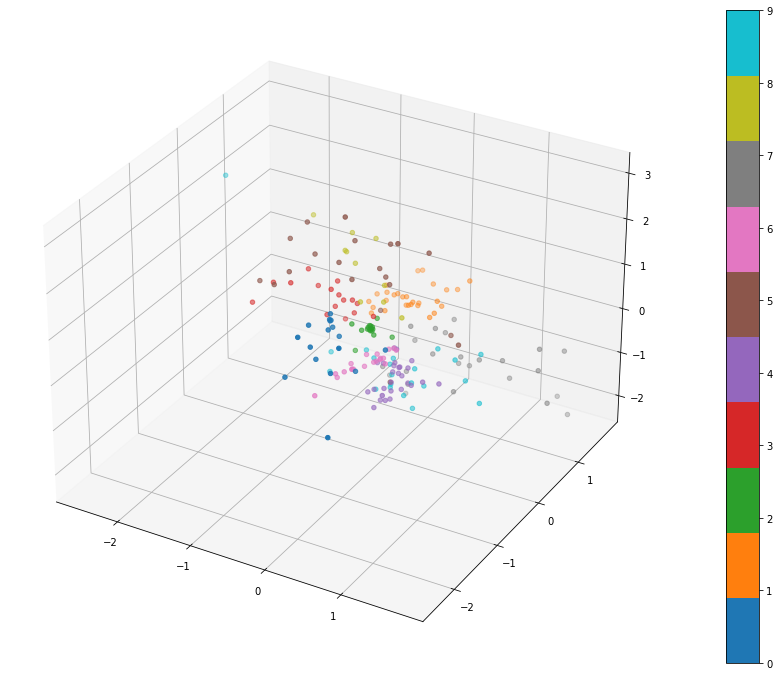


 EPOCH 28/30 	 train loss 0.031 	 val loss 0.031


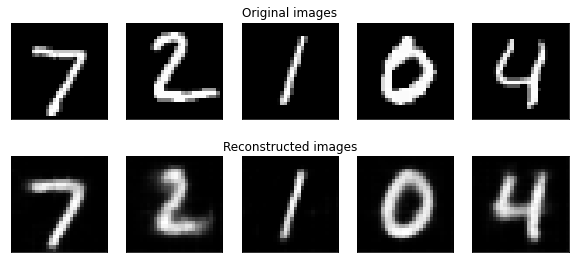

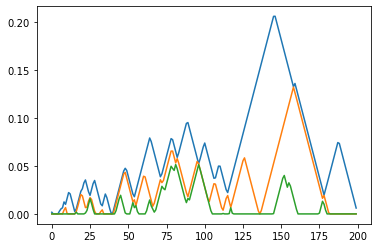

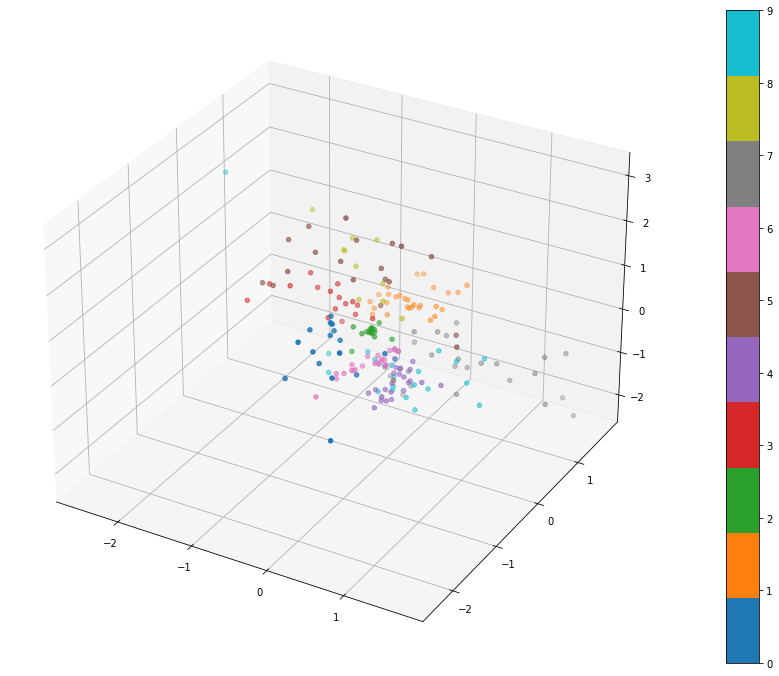


 EPOCH 29/30 	 train loss 0.030 	 val loss 0.031


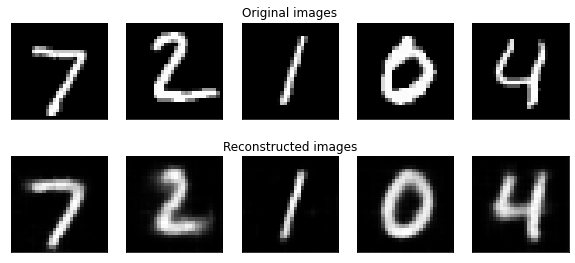

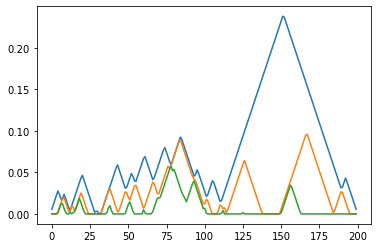

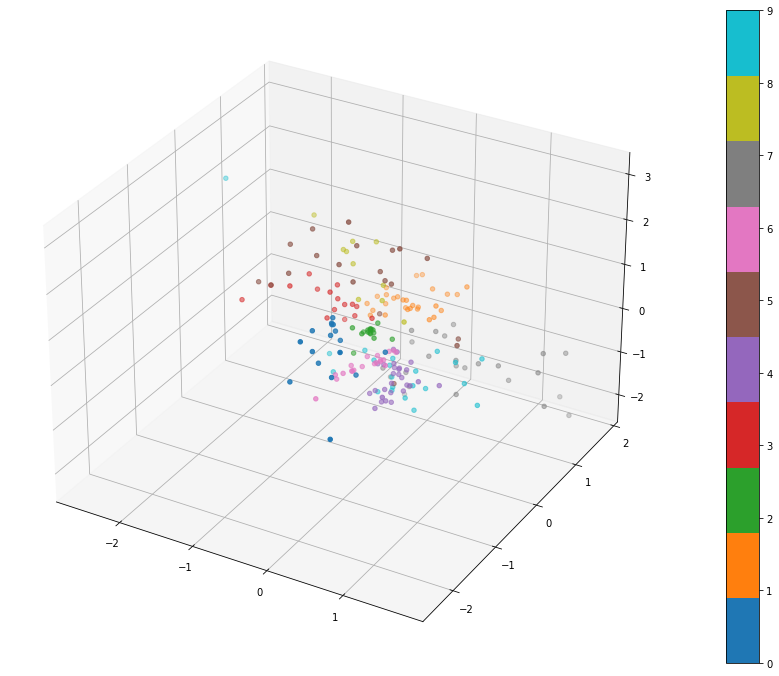


 EPOCH 30/30 	 train loss 0.030 	 val loss 0.031


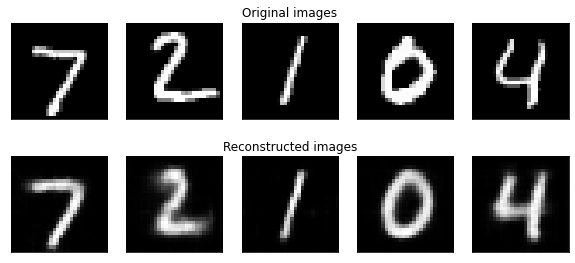

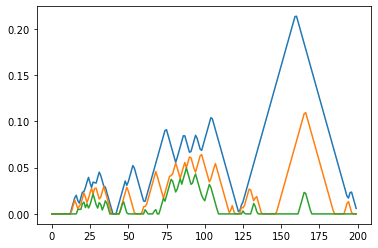

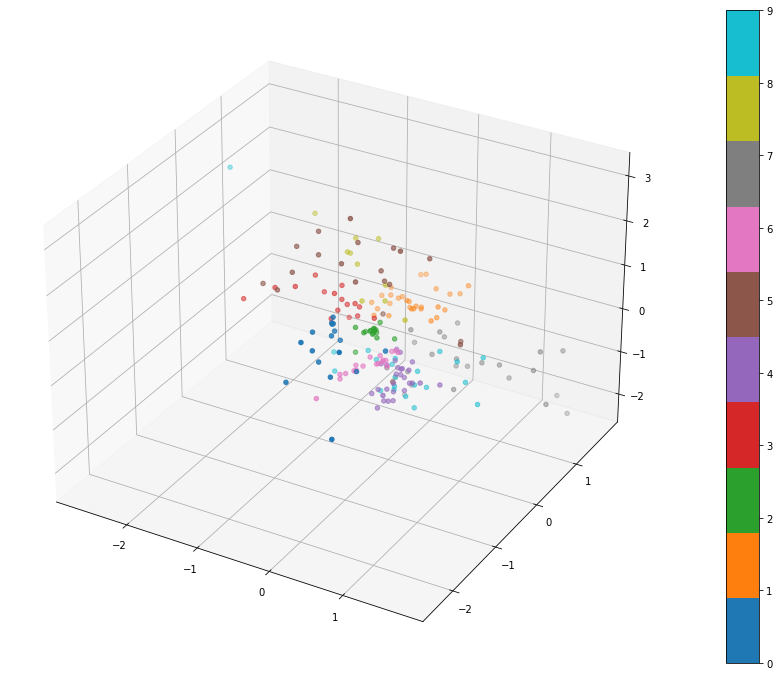

In [18]:
num_epochs = 30
history={'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs, train_loss, val_loss))
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    plot_ae_outputs(encoder, decoder, n=5)
    plot_persistence_landscapes(encoder, decoder, n=200)

In [19]:
test_epoch(encoder, decoder, device, test_loader, loss_fn).item()

0.031072502955794334

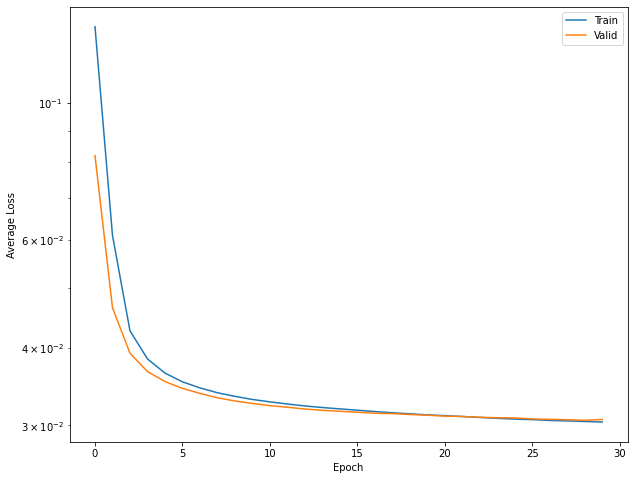

In [20]:
test_epoch(encoder, decoder, device, test_loader, loss_fn).item()# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

## Visualizations

In [21]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_samples.append([*encoded_img, label])

100%|██████████| 10000/10000 [00:03<00:00, 2502.77it/s]


In [22]:
encoded_samples = np.array(encoded_samples)

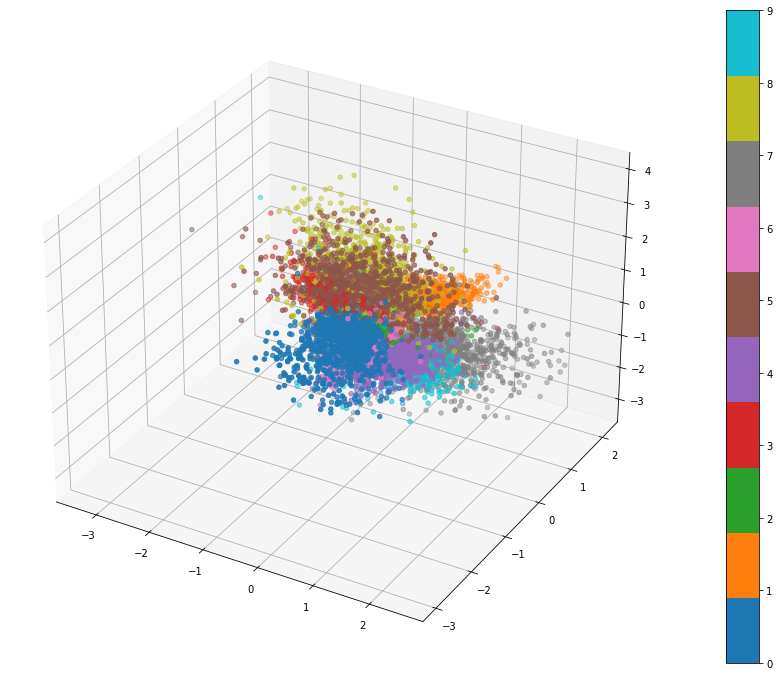

In [23]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(projection='3d')

xs, ys, zs = encoded_samples[:, 0], encoded_samples[:, 1], encoded_samples[:, 2]
labels = encoded_samples[:, 3]
sc = ax.scatter(xs, ys, zs, c=labels, cmap='tab10')
fig.colorbar(sc)
plt.show()